In [1]:
# Import `numpy` under the alias `np`
import numpy as np 

# Import `pandas` under the alias `pd`
import pandas as pd 
import pmdarima as pm

import itertools #to iterate through the loops

import statsmodels.api as sm

import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 

import plotly.express as px
import plotly.offline as py

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pandas import Series

from datetime import datetime
from matplotlib import pyplot


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#FBProphet related imports
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Importing the Auto-Arima function 
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error

 # to split the data into train and test parts
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score 


def p_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Reading the data from a file

In [2]:
df = pd.read_excel('C:/Users/ADMIN/Desktop/capstone project/Sales Forecast_Sales_Forecast_Data.xlsx')

In [3]:
df.head() # returns top n (5 by default) rows of a data frame

FIN_YEAR MONTH    STATE            FG DISTRICT  COMPANY    VALUE
0  2014-2015   Nov  Haryana  Insecticides   Rohtak  monous    675.00
1  2014-2015   Nov  Haryana  Insecticides   Rewari  monous     73.71
2  2014-2015   Nov  Haryana  Insecticides  Gurgaon  monous    405.00
3  2014-2015   Nov  Haryana  Insecticides    Mewat  monous   1188.00
4  2014-2015   Nov  Haryana  Insecticides   Palwal  monous   5188.59

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230152 entries, 0 to 230151
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FIN_YEAR  230152 non-null  object 
 1   MONTH     230152 non-null  object 
 2   STATE     230152 non-null  object 
 3   FG        230152 non-null  object 
 4   DISTRICT  230152 non-null  object 
 5   COMPANY   230152 non-null  object 
 6   VALUE     230152 non-null  float64
dtypes: float64(1), object(6)
memory usage: 12.3+ MB


# Data Preparation for modelling : using ABC Manufacturing data only

In [5]:
#Constants used within this file
train_start_date = '2014-01-01'
train_end_date = '2016-12-01'
test_start_date = '2017-01-01'
test_end_date = '2017-12-01'
consider_rolling_window = False
consider_mean_values = True
predict_periods=12
missing_record_index = 37

In [6]:
if consider_rolling_window == False:
    rolling_period = 3
else:
    #do not change this value
    rolling_period = 1     

In [7]:
#Creating a dataframe of ABC manufacturing
ABC_df = df.loc[df['COMPANY'] == 'ABC Manufacturing']

In [8]:
#converting year range to year  . for example  "2014-2015"  will be converted to 2014 
ABC_df['FIN_YEAR'] = ABC_df.FIN_YEAR.str.slice(0,4)

#converting month to datetime for checking stationarity  
ABC_df['MONTH'] = pd.to_datetime(ABC_df['FIN_YEAR'].astype(str)+ "-"+ ABC_df['MONTH'].astype(str) + "-1")

In [9]:
ABC_df.isnull().sum() #Checking the null values in the ABC manufacturing company

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [10]:
ABC_df.isna().sum() 

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [11]:
#Considering only Uttar Pradesh data for ABC manufacturing company only
ABC_df = ABC_df.loc[ (ABC_df['STATE'] == 'Uttar Pradesh')]
ABC_df

FIN_YEAR      MONTH          STATE            FG      DISTRICT  \
2263       2014 2014-04-01  Uttar Pradesh  Insecticides    Rae Bareli   
2264       2014 2014-04-01  Uttar Pradesh  Insecticides        Etawah   
2265       2014 2014-04-01  Uttar Pradesh  Insecticides  Kanpur Dehat   
2266       2014 2014-04-01  Uttar Pradesh  Insecticides  Kanpur Nagar   
2267       2014 2014-04-01  Uttar Pradesh  Insecticides        Jalaun   
...         ...        ...            ...           ...           ...   
229858     2016 2016-01-01  Uttar Pradesh  Bactericides      Mirzapur   
230144     2016 2016-12-01  Uttar Pradesh  Bactericides      Faizabad   
230145     2016 2016-12-01  Uttar Pradesh  Bactericides         Basti   
230146     2016 2016-12-01  Uttar Pradesh  Bactericides        Ballia   
230147     2016 2016-12-01  Uttar Pradesh  Bactericides          Etah   

                  COMPANY    VALUE  
2263    ABC Manufacturing  978.075  
2264    ABC Manufacturing   39.015  
2265    ABC Manufacturing    0.000  
2266    ABC Manufacturing  196.965  
2267    ABC Manufacturing  515.700  
...                   ...      ...  
229858  ABC Manufacturing    0.000  
230144  ABC Manufacturing    0.000  
230145  ABC Manufacturing    0.000  
230146  ABC Manufacturing    0.000  
230147  ABC Manufacturing    0.000  

[13024 rows x 7 columns]

In [12]:
ABC_df.describe()

VALUE
count  13024.000000
mean    2687.703816
std     5198.805612
min        0.000000
25%        0.000000
50%      195.547500
75%     3304.800000
max    69828.750000

In [13]:
ABC_df_Pesticides = ABC_df.copy(deep=True)
ABC_df_Pesticides.drop(['FIN_YEAR', 'STATE', 'FG', 'DISTRICT', 'COMPANY'],axis=1,inplace = True)

In [14]:
# Upon inspection it is found that for a period of Feb and March in 2017, there was no data. 
# We need to treat this data else seasonal_decompose() will throw error

In [15]:
# SUM 

if consider_mean_values == False:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].sum().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':595022.985}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':1698554.106 }
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])                                 

In [16]:
# MEAN 

if consider_mean_values == True:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].mean().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':2077 }
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':5897 }
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])
    

In [17]:
ABC_df_Pesticides

MONTH        VALUE
0   2014-01-01 00:00:00  2838.262500
1   2014-02-01 00:00:00  2332.428275
2   2014-03-01 00:00:00  5700.845625
3   2014-04-01 00:00:00   660.625000
4   2014-05-01 00:00:00  1593.079476
5   2014-06-01 00:00:00  1978.078821
6   2014-07-01 00:00:00  2538.479155
7   2014-08-01 00:00:00  3830.933906
8   2014-09-01 00:00:00  2614.252500
9   2014-10-01 00:00:00  2458.408125
10  2014-11-01 00:00:00  4970.405625
11  2014-12-01 00:00:00  3644.532187
12  2015-01-01 00:00:00  2742.117656
13  2015-02-01 00:00:00  1879.643438
14  2015-03-01 00:00:00  7080.092344
15  2015-04-01 00:00:00  1851.711618
16  2015-05-01 00:00:00  2693.603352
17  2015-06-01 00:00:00  2537.732935
18  2015-07-01 00:00:00  3132.405925
19  2015-08-01 00:00:00  2864.210625
20  2015-09-01 00:00:00  2864.695781
21  2015-10-01 00:00:00  2294.491875
22  2015-11-01 00:00:00  3249.614063
23  2015-12-01 00:00:00  2935.531406
24  2016-01-01 00:00:00  2874.163125
25  2016-02-01 00:00:00  2018.479219
26  2016-03-01 00:00:00  4912.333969
27  2016-04-01 00:00:00   963.712742
28  2016-05-01 00:00:00  2167.770170
29  2016-06-01 00:00:00  2011.367045
30  2016-07-01 00:00:00  1969.149375
31  2016-08-01 00:00:00  2561.995312
32  2016-09-01 00:00:00  2075.745000
33  2016-10-01 00:00:00  1407.628594
34  2016-11-01 00:00:00  3151.923750
35  2016-12-01 00:00:00  2886.590250
36  2017-01-01 00:00:00  2515.909932
37           2017-02-01  2077.000000
38           2017-03-01  5897.000000
37  2017-04-01 00:00:00   519.129844
38  2017-05-01 00:00:00  1844.698821
39  2017-06-01 00:00:00  1610.297100
40  2017-07-01 00:00:00  1923.215929
41  2017-08-01 00:00:00  2018.469375
42  2017-09-01 00:00:00  1799.250300
43  2017-10-01 00:00:00  2400.986250
44  2017-11-01 00:00:00  4115.546550
45  2017-12-01 00:00:00  3303.355050

<AxesSubplot:xlabel='MONTH', ylabel='VALUE'>

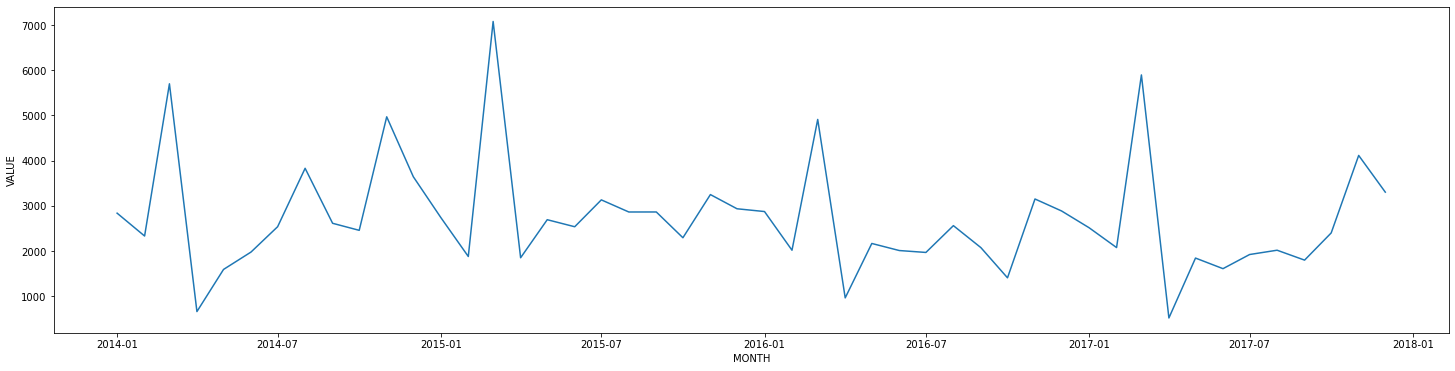

In [18]:
#Plot the data 
plt.figure(figsize=(25,6))
sns.lineplot(x="MONTH", y="VALUE", data=ABC_df_Pesticides,  ci= None)

In [19]:
if consider_rolling_window == True:
    xyzseries = ABC_df_Pesticides['VALUE'].rolling(window = rolling_period)
    XYZmean = xyzseries.mean()
    plt.figure(figsize=(25,6))
    sns.lineplot( data=XYZmean,  ci= None)
    

[Text(1, 0, 'VALUE')]

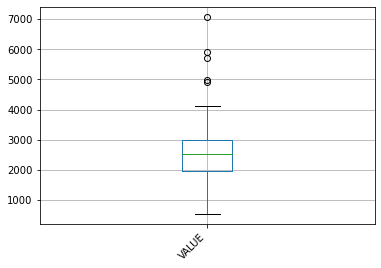

In [20]:
boxplot = ABC_df_Pesticides.boxplot(column=['VALUE'])
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [21]:
ABC_df_Pesticides.describe()

VALUE
count    48.000000
mean   2714.831248
std    1284.183176
min     519.129844
25%    1975.846460
50%    2526.821433
75%    2984.750036
max    7080.092344

In [22]:
print(ABC_df_Pesticides["VALUE"].quantile(0.95))

5445.191625


In [23]:
#ABC_df_Pesticides["VALUE"]=np.where(ABC_df_Pesticides["VALUE"]>66082.66875,66082.66875,ABC_df_Pesticides["VALUE"])

In [24]:
if consider_rolling_window == True:
    ABC_df_Pesticides['VALUE'] = XYZmean
    ABC_df_Pesticides = ABC_df_Pesticides[rolling_period - 1:]


# Check for Stationarity and Seasonality

In [25]:
# for a time series to be Sationary
# 1. Mean has to be constant 
# 2. variance has to be constant 
# 3. No seasonality

# If a timeseries has seasonality, then it is not stationary. i.e ARMA models cannot be run.

In [26]:
# Augmented Dickey FULLER test to check Stationarity

def ADF_test(timeseries):
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [27]:
ADF_test(ABC_df_Pesticides['VALUE'])

Test statistic = -8.342
P-value = 0.000
Critical values :
	1%: -3.5778480370438146 - The data is  stationary with 99% confidence
	5%: -2.925338105429433 - The data is  stationary with 95% confidence
	10%: -2.6007735310095064 - The data is  stationary with 90% confidence


In [28]:
# from the above result, as p-value < 0.05... we can conclude that the timeseries data is Stationary

In [29]:
# Additional check using KPSS method   [ Kwiatkowski–Phillips–Schmidt–Shin (KPSS)]
# Ref: https://www.statisticshowto.com/kpss-test/

stats, p, lags, critical_values = kpss(ABC_df_Pesticides['VALUE'],'c')
stats, p, lags, critical_values

print(f'Test Statistics: {stats}')
print(f'p value: {p}')
print(f'critical_values: {critical_values}')



Test Statistics: 0.2560181854156338
p value: 0.1
critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [30]:
# as 0.1  is greater than 0.05, we can conclude that the timeseries data is Stationary

In [31]:
ABC_df_Pesticides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MONTH   48 non-null     object 
 1   VALUE   48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [32]:
# Reset index after converting 'Month' to Datetime
ABC_df_Pesticides['MONTH'] = pd.to_datetime(ABC_df_Pesticides['MONTH'])
ABC_df_Pesticides.set_index('MONTH', inplace=True)

In [33]:
ABC_df_Pesticides

VALUE
MONTH                  
2014-01-01  2838.262500
2014-02-01  2332.428275
2014-03-01  5700.845625
2014-04-01   660.625000
2014-05-01  1593.079476
2014-06-01  1978.078821
2014-07-01  2538.479155
2014-08-01  3830.933906
2014-09-01  2614.252500
2014-10-01  2458.408125
2014-11-01  4970.405625
2014-12-01  3644.532187
2015-01-01  2742.117656
2015-02-01  1879.643438
2015-03-01  7080.092344
2015-04-01  1851.711618
2015-05-01  2693.603352
2015-06-01  2537.732935
2015-07-01  3132.405925
2015-08-01  2864.210625
2015-09-01  2864.695781
2015-10-01  2294.491875
2015-11-01  3249.614063
2015-12-01  2935.531406
2016-01-01  2874.163125
2016-02-01  2018.479219
2016-03-01  4912.333969
2016-04-01   963.712742
2016-05-01  2167.770170
2016-06-01  2011.367045
2016-07-01  1969.149375
2016-08-01  2561.995312
2016-09-01  2075.745000
2016-10-01  1407.628594
2016-11-01  3151.923750
2016-12-01  2886.590250
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

<AxesSubplot:xlabel='MONTH'>

<Figure size 2160x2520 with 0 Axes>

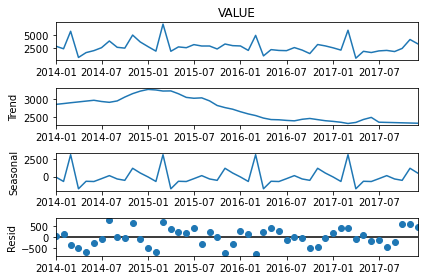

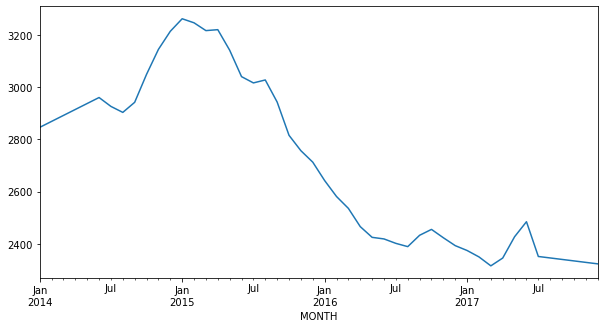

In [34]:
res = sm.tsa.seasonal_decompose(ABC_df_Pesticides['VALUE'],model = 'additive',extrapolate_trend='freq')

plt.figure(figsize=(30,35))
resplot = res.plot(observed=True)

plt.figure(figsize=(10, 5))
res.trend.plot()

# FBProphet Model

In [35]:
ABC_df_Pesticides_FBP =  ABC_df_Pesticides.copy(deep=True)

In [36]:
ABC_df_Pesticides_FBP = ABC_df_Pesticides_FBP.reset_index()[['MONTH','VALUE']].rename({'MONTH':'ds','VALUE':'y'}, axis='columns')

In [37]:
train = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] <= pd.to_datetime(train_end_date)]
train

ds            y
0  2014-01-01  2838.262500
1  2014-02-01  2332.428275
2  2014-03-01  5700.845625
3  2014-04-01   660.625000
4  2014-05-01  1593.079476
5  2014-06-01  1978.078821
6  2014-07-01  2538.479155
7  2014-08-01  3830.933906
8  2014-09-01  2614.252500
9  2014-10-01  2458.408125
10 2014-11-01  4970.405625
11 2014-12-01  3644.532187
12 2015-01-01  2742.117656
13 2015-02-01  1879.643438
14 2015-03-01  7080.092344
15 2015-04-01  1851.711618
16 2015-05-01  2693.603352
17 2015-06-01  2537.732935
18 2015-07-01  3132.405925
19 2015-08-01  2864.210625
20 2015-09-01  2864.695781
21 2015-10-01  2294.491875
22 2015-11-01  3249.614063
23 2015-12-01  2935.531406
24 2016-01-01  2874.163125
25 2016-02-01  2018.479219
26 2016-03-01  4912.333969
27 2016-04-01   963.712742
28 2016-05-01  2167.770170
29 2016-06-01  2011.367045
30 2016-07-01  1969.149375
31 2016-08-01  2561.995312
32 2016-09-01  2075.745000
33 2016-10-01  1407.628594
34 2016-11-01  3151.923750
35 2016-12-01  2886.590250

In [38]:
test = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] > pd.to_datetime(train_end_date)]
test

ds            y
36 2017-01-01  2515.909932
37 2017-02-01  2077.000000
38 2017-03-01  5897.000000
39 2017-04-01   519.129844
40 2017-05-01  1844.698821
41 2017-06-01  1610.297100
42 2017-07-01  1923.215929
43 2017-08-01  2018.469375
44 2017-09-01  1799.250300
45 2017-10-01  2400.986250
46 2017-11-01  4115.546550
47 2017-12-01  3303.355050

In [39]:
test.rename({'ds' : 'MONTH','y' : 'VALUE'},axis=1,inplace=True)
test.set_index('MONTH', inplace=True)

In [40]:
test

VALUE
MONTH                  
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

In [41]:
#run the model with confidence interval of 95%
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [42]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
m.params

{'k': array([[0.10891914]]),
 'm': array([[0.36879338]]),
 'delta': array([[ 5.59849891e-10, -4.96658962e-10, -7.72215391e-11,
         -3.84570197e-10, -8.82656303e-10,  4.18054448e-10,
         -1.39682474e-08, -1.19543273e-05, -1.27353070e-04,
         -2.07204609e-04, -5.29096876e-04, -5.63113156e-04,
         -7.32390709e-04, -3.28643140e-01, -8.81108847e-04,
         -1.26303778e-04, -1.18839258e-04, -1.39798134e-04,
         -9.97232262e-07,  1.12772155e-10, -2.30061865e-10,
         -4.72611327e-11, -5.97603527e-10,  3.04513753e-10,
         -3.20232563e-10]]),
 'sigma_obs': array([[0.04555928]]),
 'beta': array([[-5.01036741e-02,  2.03246530e-02,  1.44194403e-01,
          2.96018022e-01,  2.35986413e-01, -1.35812964e-03,
         -1.58982652e-01, -3.26588817e-01, -1.50468549e-01,
         -1.80149259e-01, -3.76233785e-01,  2.97514130e-02,
         -1.20909038e-01,  2.25203253e-01, -1.70677015e-01,
          2.22580431e-01,  2.85963880e-01, -2.55942668e-04,
          2.1150834

In [44]:
future = m.make_future_dataframe(periods=predict_periods,freq='MS')

In [45]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds         yhat   yhat_lower   yhat_upper
0  2014-01-01  2749.081045  2111.713388  3387.319846
1  2014-02-01  2258.400303  1608.321833  2831.727142
2  2014-03-01  6026.056731  5396.961615  6605.586568
3  2014-04-01  1154.269529   527.052361  1806.249163
4  2014-05-01  2145.084534  1496.460792  2779.610170
5  2014-06-01  2227.246349  1598.372566  2843.116547
6  2014-07-01  2724.505379  2081.101403  3366.153093
7  2014-08-01  3252.818864  2582.592977  3865.082244
8  2014-09-01  2765.065085  2144.693888  3375.817612
9  2014-10-01  2374.156726  1735.677689  2998.947321
10 2014-11-01  4101.667901  3546.176630  4732.986081
11 2014-12-01  3471.947951  2853.493580  4043.905437
12 2015-01-01  3020.640589  2393.688848  3710.124793
13 2015-02-01  2300.410523  1689.294916  2881.180372
14 2015-03-01  6722.835479  6093.026572  7360.754010
15 2015-04-01  1364.869858   735.303701  1964.969887
16 2015-05-01  2168.640920  1528.594250  2797.616018
17 2015-06-01  2237.201505  1549.784114  2880.502120
18 2015-07-01  2911.549271  2274.254464  3566.792339
19 2015-08-01  3196.142296  2594.663496  3812.638816
20 2015-09-01  2747.483710  2083.230092  3387.224942
21 2015-10-01  2366.684654  1731.799295  2972.513990
22 2015-11-01  3849.505630  3193.722124  4513.016862
23 2015-12-01  3051.661876  2375.652584  3700.244178
24 2016-01-01  2685.968585  2070.799445  3337.289559
25 2016-02-01  1673.820247  1025.877520  2255.203603
26 2016-03-01  4944.743598  4315.393677  5623.213913
27 2016-04-01   957.607561   264.102972  1603.157749
28 2016-05-01  2140.243080  1527.547074  2803.916284
29 2016-06-01  2062.437050  1410.175618  2697.728279
30 2016-07-01  2002.825640  1389.535221  2632.143467
31 2016-08-01  2807.647550  2112.970046  3428.118348
32 2016-09-01  2041.345152  1362.049446  2658.338391
33 2016-10-01  1419.386453   759.039916  2009.922108
34 2016-11-01  3421.397371  2764.543046  4067.645705
35 2016-12-01  2943.909000  2314.419292  3647.728393
36 2017-01-01  2120.772012  1474.634642  2754.455011
37 2017-02-01  1796.687450  1165.972855  2428.872768
38 2017-03-01  4839.051076  4200.118906  5485.821497
39 2017-04-01   378.586649  -252.513573  1026.732262
40 2017-05-01  1429.628674   786.478764  2069.990512
41 2017-06-01  1394.566314   718.541544  2031.617201
42 2017-07-01  1580.868313   945.848556  2227.386386
43 2017-08-01  2214.197434  1582.915309  2886.837553
44 2017-09-01  1552.092705   868.962293  2246.941782
45 2017-10-01  1014.541397   404.057581  1633.217168
46 2017-11-01  2846.750945  2162.405400  3452.666469
47 2017-12-01  2257.669149  1610.371823  2871.677222

<AxesSubplot:xlabel='ds'>

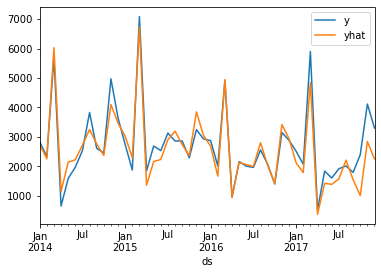

In [46]:
pd.concat([ABC_df_Pesticides_FBP.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

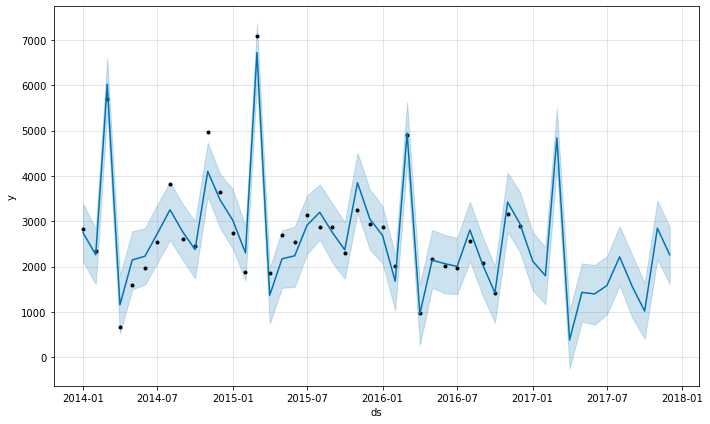

In [47]:
fig1 = m.plot(forecast)

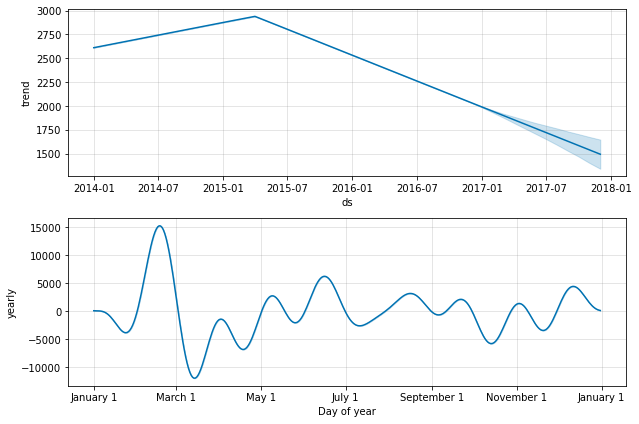

In [48]:
fig2 = m.plot_components(forecast)

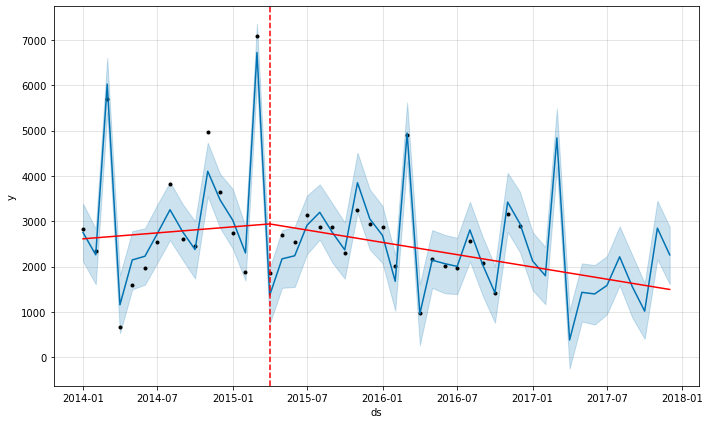

In [49]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [50]:
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [51]:
#check for cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '120 days')
cv_results

INFO:fbprophet:Making 4 forecasts with cutoffs between 2016-02-05 00:00:00 and 2016-08-03 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


ds         yhat   yhat_lower   yhat_upper            y     cutoff
0  2016-03-01  5287.318824  4566.784436  5986.364442  4912.333969 2016-02-05
1  2016-04-01  1238.196761   528.011133  1923.612740   963.712742 2016-02-05
2  2016-05-01  2335.841502  1633.447769  3010.219876  2167.770170 2016-02-05
3  2016-06-01  3153.307210  2431.495153  3839.394220  2011.367045 2016-02-05
4  2016-05-01  2411.832532  1811.733381  3018.217417  2167.770170 2016-04-05
5  2016-06-01  3074.842728  2453.014790  3757.353911  2011.367045 2016-04-05
6  2016-07-01  2366.122708  1722.655211  2953.955698  1969.149375 2016-04-05
7  2016-08-01  5494.621203  4882.355416  6101.612337  2561.995312 2016-04-05
8  2016-07-01  2463.865284  1870.308205  3039.051620  1969.149375 2016-06-04
9  2016-08-01  5473.871041  4854.862833  6033.385893  2561.995312 2016-06-04
10 2016-09-01   582.773564    -4.046201  1135.903531  2075.745000 2016-06-04
11 2016-10-01   316.456786  -256.184440   917.564228  1407.628594 2016-06-04
12 2016-09-01  1136.232401   556.173884  1724.033953  2075.745000 2016-08-03
13 2016-10-01   625.761602    40.798686  1206.436124  1407.628594 2016-08-03
14 2016-11-01  5586.110801  5021.312377  6200.311297  3151.923750 2016-08-03
15 2016-12-01  2235.089491  1632.511529  2806.741746  2886.590250 2016-08-03

In [52]:
#Check performance metrics
df_p = performance_metrics(cv_results)
df_p

horizon           mse         rmse          mae      mape     mdape  \
0   25 days  1.406136e+05   374.984856   374.984856  0.076335  0.076335   
1   26 days  5.956644e+04   244.062361   244.062361  0.112587  0.112587   
2   27 days  2.447438e+05   494.715909   494.715909  0.251233  0.251233   
3   29 days  8.826839e+05   939.512599   939.512599  0.452615  0.452615   
4   56 days  7.534148e+04   274.484019   274.484019  0.284819  0.284819   
5   57 days  1.130981e+06  1063.475682  1063.475682  0.528733  0.528733   
6   58 days  8.479020e+06  2911.875729  2911.875729  1.136566  1.136566   
7   59 days  6.113160e+05   781.866992   781.866992  0.555450  0.555450   
8   86 days  2.824797e+04   168.071331   168.071331  0.077532  0.077532   
9   87 days  1.575878e+05   396.973333   396.973333  0.201596  0.201596   
10  89 days  2.228964e+06  1492.971436  1492.971436  0.719246  0.719246   
11  90 days  5.925267e+06  2434.187051  2434.187051  0.772286  0.772286   
12 117 days  1.304027e+06  1141.940164  1141.940164  0.567743  0.567743   
13 118 days  8.600295e+06  2932.625891  2932.625891  1.144665  1.144665   
14 119 days  1.190656e+06  1091.171808  1091.171808  0.775184  0.775184   
15 120 days  4.244532e+05   651.500759   651.500759  0.225699  0.225699   

    coverage  
0        1.0  
1        1.0  
2        1.0  
3        0.0  
4        1.0  
5        0.0  
6        0.0  
7        0.0  
8        1.0  
9        1.0  
10       0.0  
11       0.0  
12       0.0  
13       0.0  
14       0.0  
15       0.0

In [53]:
forecast_FBP = forecast.loc[forecast['ds'] > pd.to_datetime(train_end_date)]
forecast_FBP.rename(columns={ 'ds' : 'MONTH'},inplace = True)
forecast_FBP['MONTH'] = pd.to_datetime(forecast_FBP['MONTH'])
forecast_FBP.set_index('MONTH', inplace=True)
forecast_FBP.drop(columns =['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper'], axis = 1, inplace = True)

In [54]:
forecast_FBP

yhat
MONTH                  
2017-01-01  2120.772012
2017-02-01  1796.687450
2017-03-01  4839.051076
2017-04-01   378.586649
2017-05-01  1429.628674
2017-06-01  1394.566314
2017-07-01  1580.868313
2017-08-01  2214.197434
2017-09-01  1552.092705
2017-10-01  1014.541397
2017-11-01  2846.750945
2017-12-01  2257.669149

In [55]:
ABC_df_Pesticides_FBP_residue = ABC_df_Pesticides_FBP.loc[forecast['ds'] > pd.to_datetime(train_end_date)]

ABC_df_Pesticides_FBP_residue.rename(columns={ 'ds' : 'MONTH', 'y' : 'VALUE'},inplace = True)
ABC_df_Pesticides_FBP_residue.set_index('MONTH', inplace=True)

In [56]:
residual_FBP = ABC_df_Pesticides_FBP_residue['VALUE'] - forecast_FBP['yhat']
residual_FBP

MONTH
2017-01-01     395.137919
2017-02-01     280.312550
2017-03-01    1057.948924
2017-04-01     140.543195
2017-05-01     415.070148
2017-06-01     215.730786
2017-07-01     342.347616
2017-08-01    -195.728059
2017-09-01     247.157595
2017-10-01    1386.444853
2017-11-01    1268.795605
2017-12-01    1045.685901
dtype: float64

In [57]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual_FBP**2)))

Root Mean Squared Error: 732.2721075928712


In [58]:
print(mean_absolute_error(test.loc[pd.to_datetime(test_start_date)] ,forecast_FBP.loc[pd.to_datetime(test_start_date)]))

395.13791934914525


In [59]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_FBP.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

22.631358798921806

# Auto Arima

In [60]:
ABC_df_Pesticides_AA = ABC_df_Pesticides.copy(deep=True)

In [61]:
model = pm.auto_arima(ABC_df_Pesticides_AA['VALUE'], m = predict_periods,seasonal= True,start_P= 0,start_q= 0,max_order= 4,test = 'adf',
                     error_action= 'ignore',suppress_warnings= True,stepwise= True,trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=2.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=575.422, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=565.614, Time=0.90 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=574.553, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=557.318, Time=4.64 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.38 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=556.244, Time=3.00 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=565.106, Time=0.57 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=558.874, Time=9.93 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=554.224, Time=4.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=561.724, Time=0.93 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=556.114, T

In [62]:
#Model suumary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood                -271.426
Date:                             Wed, 23 Jun 2021   AIC                            552.852
Time:                                     14:21:15   BIC                            560.629
Sample:                                          0   HQIC                           555.537
                                              - 48                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3628      0.248     -1.464      0.143      -0.849       0.123
ma.L2         -0.2920      0.146     -2.007      0.045      -0.577      -0.007
ar.S.L12      -0.9269      0.183     -5.061      0.000      -1.286      -0.568
ar.S.L24      -0.6064      0.119     -5.088      0.000      -0.840      -0.373
sigma2      1.914e+05   5.88e+04      3.256      0.001    7.62e+04    3.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.47   Jarque-Bera (JB):                 7.46
Prob(Q):                              0.12   Prob(JB):                         0.02
Heteroskedasticity (H):               0.41   Skew:                             0.76
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
ABC_df_Pesticides_AA

VALUE
MONTH                  
2014-01-01  2838.262500
2014-02-01  2332.428275
2014-03-01  5700.845625
2014-04-01   660.625000
2014-05-01  1593.079476
2014-06-01  1978.078821
2014-07-01  2538.479155
2014-08-01  3830.933906
2014-09-01  2614.252500
2014-10-01  2458.408125
2014-11-01  4970.405625
2014-12-01  3644.532187
2015-01-01  2742.117656
2015-02-01  1879.643438
2015-03-01  7080.092344
2015-04-01  1851.711618
2015-05-01  2693.603352
2015-06-01  2537.732935
2015-07-01  3132.405925
2015-08-01  2864.210625
2015-09-01  2864.695781
2015-10-01  2294.491875
2015-11-01  3249.614063
2015-12-01  2935.531406
2016-01-01  2874.163125
2016-02-01  2018.479219
2016-03-01  4912.333969
2016-04-01   963.712742
2016-05-01  2167.770170
2016-06-01  2011.367045
2016-07-01  1969.149375
2016-08-01  2561.995312
2016-09-01  2075.745000
2016-10-01  1407.628594
2016-11-01  3151.923750
2016-12-01  2886.590250
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

In [64]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_AA.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [65]:
train

VALUE
MONTH                  
2014-01-01  2838.262500
2014-02-01  2332.428275
2014-03-01  5700.845625
2014-04-01   660.625000
2014-05-01  1593.079476
2014-06-01  1978.078821
2014-07-01  2538.479155
2014-08-01  3830.933906
2014-09-01  2614.252500
2014-10-01  2458.408125
2014-11-01  4970.405625
2014-12-01  3644.532187
2015-01-01  2742.117656
2015-02-01  1879.643438
2015-03-01  7080.092344
2015-04-01  1851.711618
2015-05-01  2693.603352
2015-06-01  2537.732935
2015-07-01  3132.405925
2015-08-01  2864.210625
2015-09-01  2864.695781
2015-10-01  2294.491875
2015-11-01  3249.614063
2015-12-01  2935.531406
2016-01-01  2874.163125
2016-02-01  2018.479219
2016-03-01  4912.333969
2016-04-01   963.712742
2016-05-01  2167.770170
2016-06-01  2011.367045
2016-07-01  1969.149375
2016-08-01  2561.995312
2016-09-01  2075.745000
2016-10-01  1407.628594
2016-11-01  3151.923750
2016-12-01  2886.590250

In [66]:
test

VALUE
MONTH                  
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

In [67]:
#Fitting the model in the train set
model.fit(train['VALUE'])

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [68]:
#Forecasting the train model and comparing the value
forecast = model.predict(n_periods=predict_periods,return_conf_int=True)

In [69]:
#Printing the forecast values in the test set
forecast

(array([2947.6133008 , 2331.4162428 , 5790.93578544,  835.99461605,
        1786.46391794, 2082.72256882, 2590.94714989, 3705.62175128,
        2644.36280273, 2411.686096  , 4740.00061298, 3584.46545023]),
 array([[1960.4274393 , 3934.79916231],
        [1244.3718705 , 3418.46061509],
        [4670.41978564, 6911.45178524],
        [-317.02175169, 1989.0109838 ],
        [ 601.83849918, 2971.0893367 ],
        [ 867.30987296, 3298.13526467],
        [1345.50800656, 3836.38629321],
        [2430.86322583, 4980.38027673],
        [1340.94424498, 3947.78136048],
        [1080.22427711, 3743.14791489],
        [3381.07411988, 6098.92710608],
        [2198.61847017, 4970.31243028]]))

In [70]:
#Resttin the forecast df to and creating the column name for prediction
forecast_df=pd.DataFrame(forecast[0],index= test.index,columns=['Prediction'])

In [71]:
#Printing the dataframe for forecast_dfABC_df
forecast_df

Prediction
MONTH                  
2017-01-01  2947.613301
2017-02-01  2331.416243
2017-03-01  5790.935785
2017-04-01   835.994616
2017-05-01  1786.463918
2017-06-01  2082.722569
2017-07-01  2590.947150
2017-08-01  3705.621751
2017-09-01  2644.362803
2017-10-01  2411.686096
2017-11-01  4740.000613
2017-12-01  3584.465450

<AxesSubplot:xlabel='MONTH'>

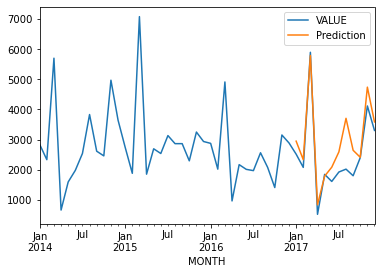

In [72]:
#Conactenating the observed and forecast model and plotting the graph
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast_df],axis=1).plot()

In [73]:
forecast1 = model.predict(n_periods=predict_periods,return_conf_int=True)
forecast1

(array([2947.6133008 , 2331.4162428 , 5790.93578544,  835.99461605,
        1786.46391794, 2082.72256882, 2590.94714989, 3705.62175128,
        2644.36280273, 2411.686096  , 4740.00061298, 3584.46545023]),
 array([[1960.4274393 , 3934.79916231],
        [1244.3718705 , 3418.46061509],
        [4670.41978564, 6911.45178524],
        [-317.02175169, 1989.0109838 ],
        [ 601.83849918, 2971.0893367 ],
        [ 867.30987296, 3298.13526467],
        [1345.50800656, 3836.38629321],
        [2430.86322583, 4980.38027673],
        [1340.94424498, 3947.78136048],
        [1080.22427711, 3743.14791489],
        [3381.07411988, 6098.92710608],
        [2198.61847017, 4970.31243028]]))

In [74]:
forecast_range=pd.date_range(start= pd.to_datetime(test_start_date) ,periods= predict_periods,freq='MS')
forecast_range

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [75]:
forecast1_df = pd.DataFrame(forecast1[0],index= forecast_range,columns=['Prediction'])

In [76]:
forecast1_df

Prediction
2017-01-01  2947.613301
2017-02-01  2331.416243
2017-03-01  5790.935785
2017-04-01   835.994616
2017-05-01  1786.463918
2017-06-01  2082.722569
2017-07-01  2590.947150
2017-08-01  3705.621751
2017-09-01  2644.362803
2017-10-01  2411.686096
2017-11-01  4740.000613
2017-12-01  3584.465450

<AxesSubplot:>

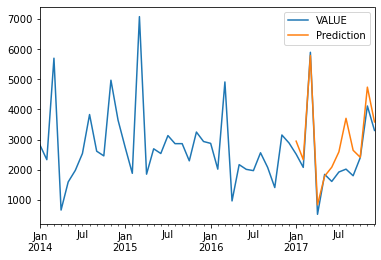

In [77]:
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast1_df],axis=1).plot()

In [78]:
lower = pd.Series(forecast1[1][:,0],index=forecast_range)
upper = pd.Series(forecast1[1][:,1],index=forecast_range)

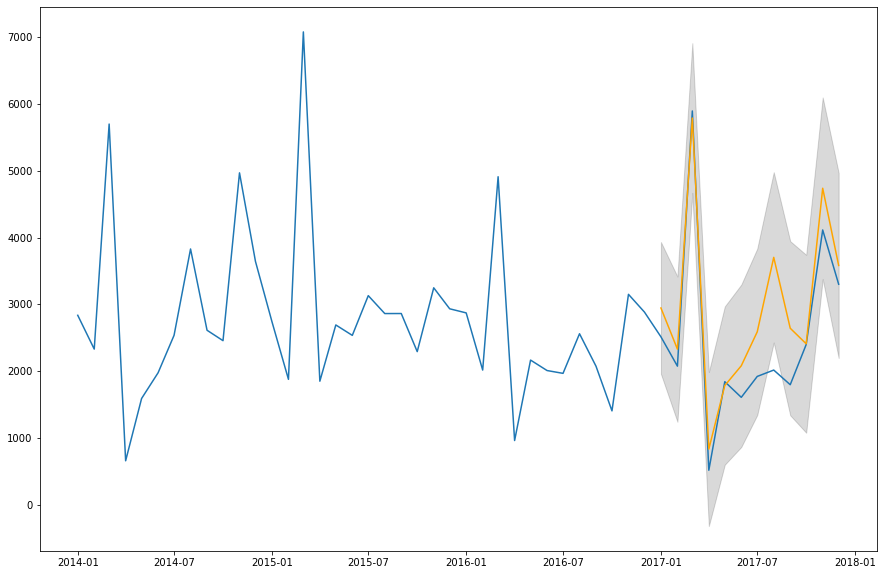

In [79]:
plt.figure(figsize=(15,10))
plt.plot(ABC_df_Pesticides_AA['VALUE'])
plt.plot(forecast1_df,color = 'orange')
plt.fill_between(forecast_range,lower,upper,color = 'k',alpha = .15)


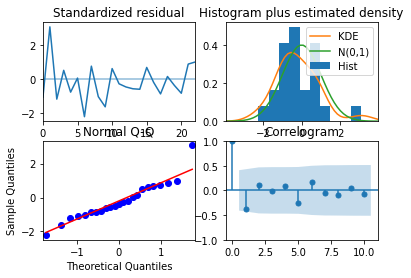

In [80]:
out = model.plot_diagnostics()

In [81]:
residuals_AA = test['VALUE'] - forecast_df['Prediction']
residuals_AA

MONTH
2017-01-01    -431.703369
2017-02-01    -254.416243
2017-03-01     106.064215
2017-04-01    -316.864772
2017-05-01      58.234903
2017-06-01    -472.425469
2017-07-01    -667.731221
2017-08-01   -1687.152376
2017-09-01    -845.112503
2017-10-01     -10.699846
2017-11-01    -624.454063
2017-12-01    -281.110400
dtype: float64

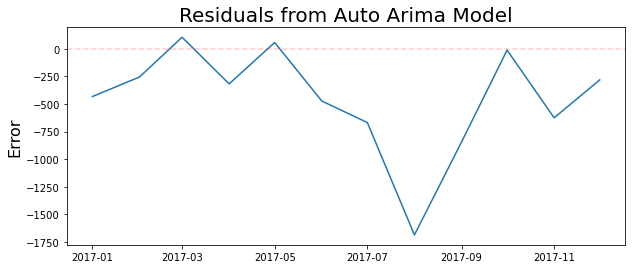

In [82]:
plt.figure(figsize=(10,4))
plt.plot(residuals_AA)
plt.title('Residuals from Auto Arima Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

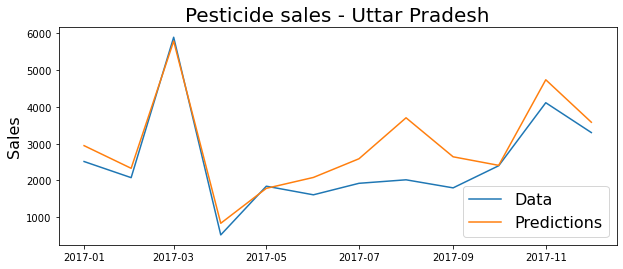

In [83]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(forecast_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Uttar Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [84]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_AA**2)))

Root Mean Squared Error: 649.6774289146238


In [85]:
print(mean_absolute_error(test['VALUE'] ,forecast_df['Prediction']))

479.66411502580576


In [86]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

26.17859536026565

# ARMA model

In [87]:
ABC_df_Pesticides_ARMA = ABC_df_Pesticides.copy(deep=True)

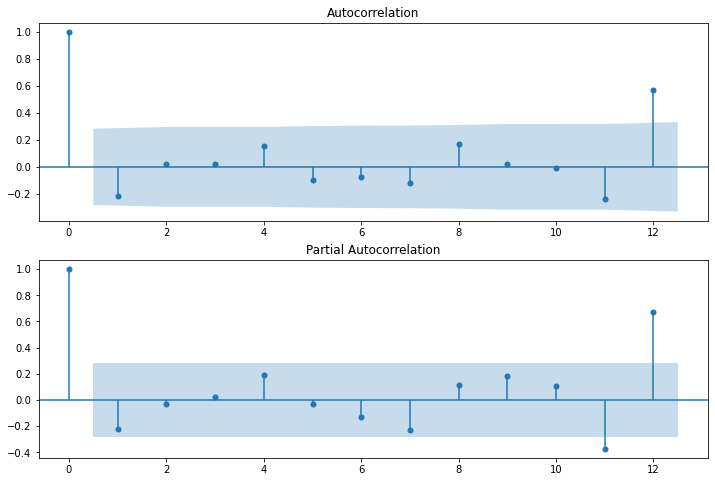

In [88]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax1)
ax2=fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax2)

In [89]:
train = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_ARMA.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [90]:
train

VALUE
MONTH                  
2014-01-01  2838.262500
2014-02-01  2332.428275
2014-03-01  5700.845625
2014-04-01   660.625000
2014-05-01  1593.079476
2014-06-01  1978.078821
2014-07-01  2538.479155
2014-08-01  3830.933906
2014-09-01  2614.252500
2014-10-01  2458.408125
2014-11-01  4970.405625
2014-12-01  3644.532187
2015-01-01  2742.117656
2015-02-01  1879.643438
2015-03-01  7080.092344
2015-04-01  1851.711618
2015-05-01  2693.603352
2015-06-01  2537.732935
2015-07-01  3132.405925
2015-08-01  2864.210625
2015-09-01  2864.695781
2015-10-01  2294.491875
2015-11-01  3249.614063
2015-12-01  2935.531406
2016-01-01  2874.163125
2016-02-01  2018.479219
2016-03-01  4912.333969
2016-04-01   963.712742
2016-05-01  2167.770170
2016-06-01  2011.367045
2016-07-01  1969.149375
2016-08-01  2561.995312
2016-09-01  2075.745000
2016-10-01  1407.628594
2016-11-01  3151.923750
2016-12-01  2886.590250

In [91]:
# define model
model = ARMA(train, order=(1,1))

In [92]:
model_fit = model.fit()

In [93]:
#summary of the model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  VALUE   No. Observations:                   36
Model:                     ARMA(1, 1)   Log Likelihood                -306.465
Method:                       css-mle   S.D. of innovations           1203.657
Date:                Wed, 23 Jun 2021   AIC                            620.930
Time:                        14:21:37   BIC                            627.264
Sample:                    01-01-2014   HQIC                           623.141
                         - 12-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2784.5756    156.342     17.811      0.000    2478.151    3091.000
ar.L1.VALUE    -0.0988      0.484     -0.204      0.838      -1.048       0.851
ma.L1.VALUE    -0.1500      0.468     -0.320    

In [94]:
test

VALUE
MONTH                  
2017-01-01  2515.909932
2017-02-01  2077.000000
2017-03-01  5897.000000
2017-04-01   519.129844
2017-05-01  1844.698821
2017-06-01  1610.297100
2017-07-01  1923.215929
2017-08-01  2018.469375
2017-09-01  1799.250300
2017-10-01  2400.986250
2017-11-01  4115.546550
2017-12-01  3303.355050

In [95]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALUE   12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


In [96]:
#get the predictions and residuals
predictions = model_fit.predict(start=pd.to_datetime(test_start_date), end = pd.to_datetime(test_end_date))

In [97]:
predictions

2017-01-01    2753.827037
2017-02-01    2787.614980
2017-03-01    2784.275109
2017-04-01    2784.605248
2017-05-01    2784.572615
2017-06-01    2784.575840
2017-07-01    2784.575522
2017-08-01    2784.575553
2017-09-01    2784.575550
2017-10-01    2784.575550
2017-11-01    2784.575550
2017-12-01    2784.575550
Freq: MS, dtype: float64

In [98]:
Pred_range=pd.date_range(start = pd.to_datetime(test_end_date),periods= predict_periods,freq='MS')
Pred_range

DatetimeIndex(['2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01'],
              dtype='datetime64[ns]', freq='MS')

In [99]:
Pred_df = predictions.to_frame()
Pred_df.info()
Pred_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-01-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


0
2017-01-01  2753.827037
2017-02-01  2787.614980
2017-03-01  2784.275109
2017-04-01  2784.605248
2017-05-01  2784.572615
2017-06-01  2784.575840
2017-07-01  2784.575522
2017-08-01  2784.575553
2017-09-01  2784.575550
2017-10-01  2784.575550
2017-11-01  2784.575550
2017-12-01  2784.575550

In [100]:
Pred_df.columns = ['PRED_VALUE']

In [101]:
residuals_ARMA = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_ARMA

MONTH
2017-01-01    -237.917105
2017-02-01    -710.614980
2017-03-01    3112.724891
2017-04-01   -2265.475405
2017-05-01    -939.873793
2017-06-01   -1174.278740
2017-07-01    -861.359592
2017-08-01    -766.106178
2017-09-01    -985.325250
2017-10-01    -383.589300
2017-11-01    1330.971000
2017-12-01     518.779500
dtype: float64

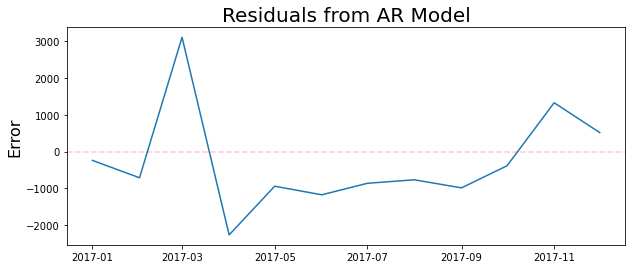

In [102]:
plt.figure(figsize=(10,4))
plt.plot(residuals_ARMA)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

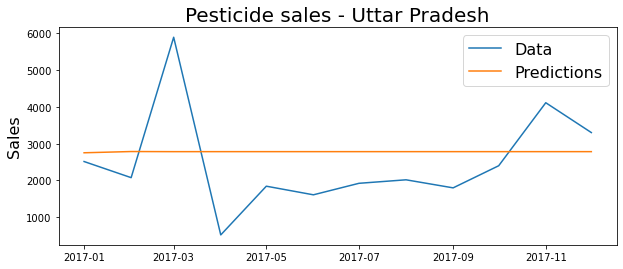

In [103]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(Pred_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Uttar Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [104]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_ARMA**2)))

Root Mean Squared Error: 1358.0865264552529


In [105]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

1107.251311303381


In [106]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

71.5210849426681

# SARIMAX Model

In [107]:
ABC_df_Pesticides_SARIMAX = ABC_df_Pesticides.copy(deep=True)

In [108]:
p = range(0, 3)
d = range(0, 1)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[0], x[0], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
               
            continue            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:888.0042165264042
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:888.0042165264042
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:888.0042165264042
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:357.10509906157256
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:357.10509906157256
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:357.10509906157256
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:852.343894838562
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:852.343894838562
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:852.343894838562
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:335.00468260857156
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:335.00468260857156
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:335.00468260857156
ARIMA(0, 0, 1)

In [109]:
# Fitting the data to SARIMA model 
model = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX['VALUE'], 
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 2, 12),  
                                continueenforce_invertibility=False)

In [110]:
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2412      2.903      0.083      0.934      -5.449       5.932
ar.S.L24      -0.7408      7.083     -0.105      0.917     -14.623      13.141
ma.S.L12      -1.5099     11.398     -0.132      0.895     -23.850      20.830
ma.S.L24       0.8996     34.947      0.026      0.979     -67.595      69.394
sigma2      3.739e+05   5.51e-05   6.78e+09      0.000    3.74e+05    3.74e+05


In [111]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         VALUE   No. Observations:                   48
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood                -199.407
Date:                       Wed, 23 Jun 2021   AIC                            408.815
Time:                               14:23:49   BIC                            414.705
Sample:                           01-01-2014   HQIC                           410.378
                                - 12-01-2017                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2412      2.903      0.083      0.934      -5.449       5.932
ar.S.L24      -0.7408      7.083     -0.105      0.917     -14.623      13.141
ma.S.L12      -1.5099     11.398     -0.132      0.895     -23.850      20.830
ma.S.L24       0.8996     34.947      0.026      0.979     -67.595      69.394
sigma2      3.739e+05   5.51e-05   6.78e+09      0.000    3.74e+05    3.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.64   Prob(JB):                         0.93
Heteroskedasticity (H):               0.36   Skew:                            -0.11
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.38e+27. Standard errors may be unstable.
"""

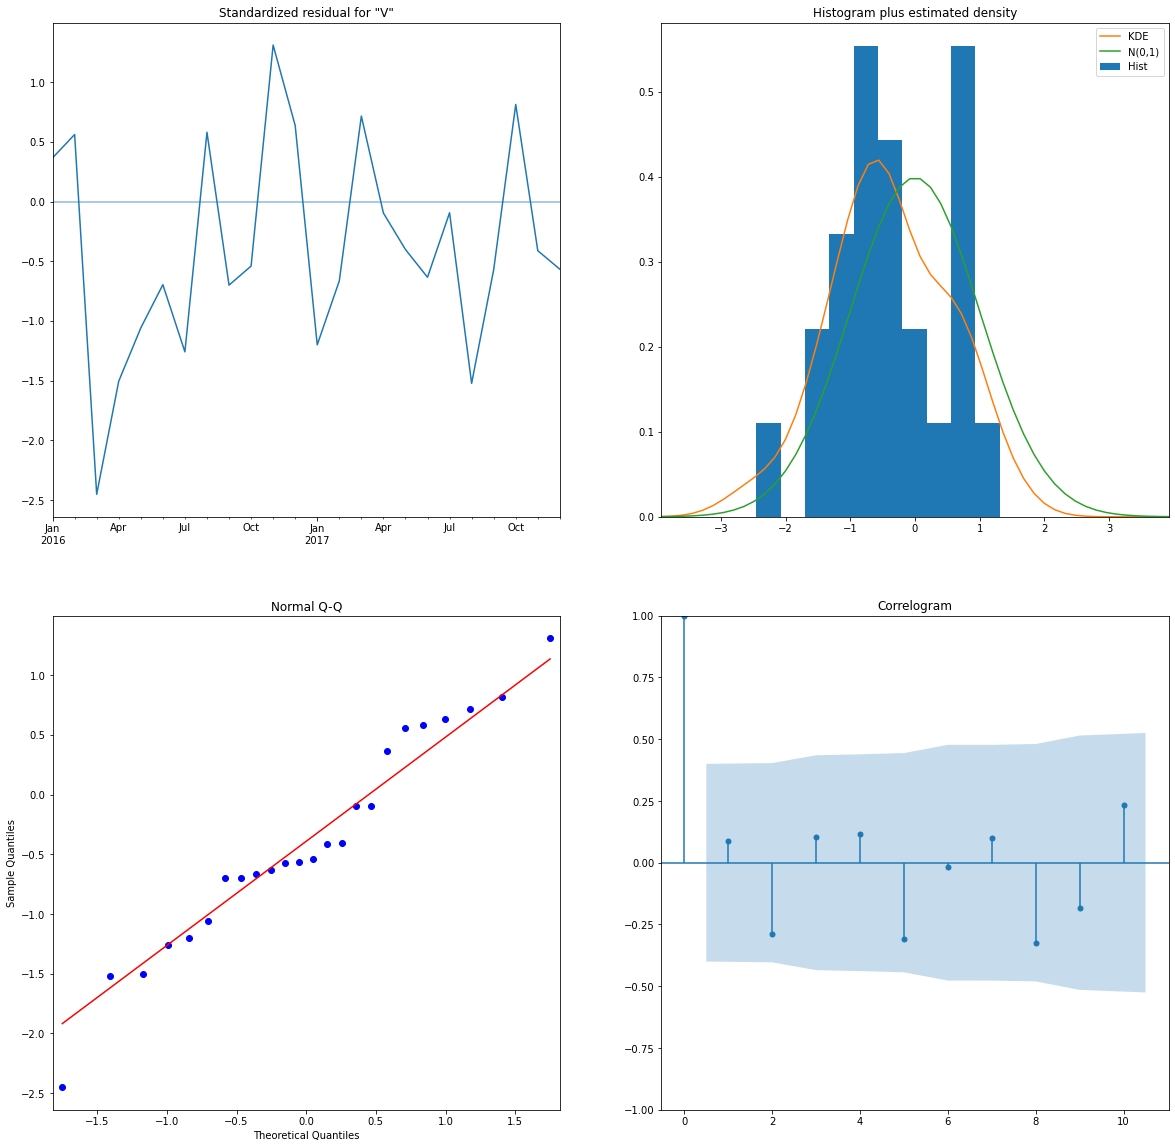

In [112]:
# Checking diagnostic plots
results.plot_diagnostics(figsize=(20, 20))
plt.show()

In [113]:
train = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_SARIMAX.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [114]:
forecast = results.predict(12)
forecast

2015-01-01    4656.268577
2015-02-01    3826.429896
2015-03-01    9352.435987
2015-04-01    1083.778343
2015-05-01    2613.502417
2015-06-01    3245.107265
2015-07-01    4164.463548
2015-08-01    6284.780625
2015-09-01    4288.772363
2015-10-01    4033.104233
2015-11-01    8154.123703
2015-12-01    5978.982107
2016-01-01    2470.957764
2016-02-01    1399.685138
2016-03-01    7617.095359
2016-04-01    2623.355072
2016-05-01    3335.592121
2016-06-01    2779.840355
2016-07-01    3357.609662
2016-08-01    1922.463730
2016-09-01    2848.139468
2016-10-01    2004.149798
2016-11-01    1706.824906
2016-12-01    2184.539696
2017-01-01    3659.946519
2017-02-01    2710.766487
2017-03-01    5214.972092
2017-04-01     611.274807
2017-05-01    2227.907459
2017-06-01    2215.126159
2017-07-01    2012.918010
2017-08-01    3469.984993
2017-09-01    2343.664418
2017-10-01    1626.246881
2017-11-01    4508.257967
2017-12-01    3843.915197
Freq: MS, Name: predicted_mean, dtype: float64

In [115]:
Predicted_df = pd.DataFrame(forecast.loc[forecast.index.isin(test.index)], columns=["PRED_VALUE"])
Predicted_df

Empty DataFrame
Columns: [PRED_VALUE]
Index: []

<AxesSubplot:>

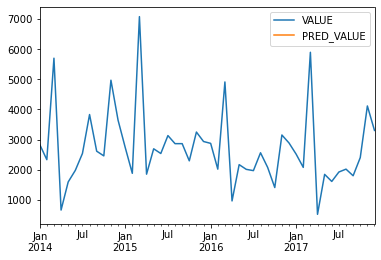

In [116]:
pd.concat([ABC_df_Pesticides_SARIMAX['VALUE'], Predicted_df], axis=1).plot()

In [117]:
residuals_SARIMAX = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_SARIMAX

MONTH
2017-01-01    -237.917105
2017-02-01    -710.614980
2017-03-01    3112.724891
2017-04-01   -2265.475405
2017-05-01    -939.873793
2017-06-01   -1174.278740
2017-07-01    -861.359592
2017-08-01    -766.106178
2017-09-01    -985.325250
2017-10-01    -383.589300
2017-11-01    1330.971000
2017-12-01     518.779500
dtype: float64

In [118]:
#get the predictions

predict_future = results.forecast(len(test))
predict_future

2018-01-01    3005.166085
2018-02-01    2415.904338
2018-03-01    8911.366752
2018-04-01    1345.024706
2018-05-01    2795.061038
2018-06-01    2372.387169
2018-07-01    3144.646839
2018-08-01    2399.673981
2018-09-01    2689.625997
2018-10-01    3525.395346
2018-11-01    4883.709460
2018-12-01    4021.148316
Freq: MS, Name: predicted_mean, dtype: float64

In [119]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_SARIMAX**2)))

Root Mean Squared Error: 1358.0865264552529


In [120]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

1107.251311303381


In [121]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

71.5210849426681

# Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [122]:
ABC_df_Pesticides_hwm =  ABC_df_Pesticides.copy(deep=True)

In [123]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [124]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_hwm.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [125]:
pred1 = ExponentialSmoothing(np.asarray(train['VALUE']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred1.params['smoothing_trend'], 4))
print('Smoothing Seasonal: ', np.round(pred1.params['smoothing_seasonal'], 4))
print('Initial Level: ', np.round(pred1.params['initial_level'], 4))
print('Initial Slope: ', np.round(pred1.params['initial_trend'], 4))
print('Initial Seasons: ', np.round(pred1.params['initial_seasons'], 4))
print('')

### Forecast for next 12 months

y_pred1 =  pred1.forecast(steps = 12)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['VALUE']})
print(df_pred1)


== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  0.3537
Smoothing Slope:  0.0533
Smoothing Seasonal:  0.4057
Initial Level:  2781.981
Initial Slope:  -46.1198
Initial Seasons:  [   46.5912  -551.4507  3118.8772 -1819.4442  -923.3886  -745.3734
  -269.082    701.1072  -196.7434  -492.2957  1708.557    728.5574]

                  Y_hat            Y
MONTH                               
2017-01-01  2253.185534  2515.909932
2017-02-01  1404.334962  2077.000000
2017-03-01  5064.130866  5897.000000
2017-04-01   493.713464   519.129844
2017-05-01  1362.247842  1844.698821
2017-06-01  1191.940780  1610.297100
2017-07-01  1437.263098  1923.215929
2017-08-01  2027.142488  2018.469375
2017-09-01  1567.602627  1799.250300
2017-10-01  1056.149323  2400.986250
2017-11-01  2854.631109  4115.546550
2017-12-01  2306.653297  3303.355050


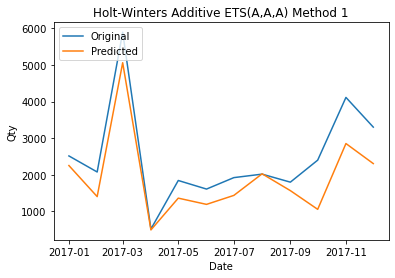

In [126]:
### Plot

fig2, ax = plt.subplots()
ax.plot(df_pred1.Y, label='Original')
ax.plot(df_pred1.Y_hat, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

In [127]:
residuals_hwm = df_pred1.Y - df_pred1.Y_hat
residuals_hwm


MONTH
2017-01-01     262.724398
2017-02-01     672.665038
2017-03-01     832.869134
2017-04-01      25.416380
2017-05-01     482.450979
2017-06-01     418.356320
2017-07-01     485.952831
2017-08-01      -8.673113
2017-09-01     231.647673
2017-10-01    1344.836927
2017-11-01    1260.915441
2017-12-01     996.701753
dtype: float64

In [128]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_hwm**2)))

Root Mean Squared Error: 724.8790027929145


In [129]:
print(mean_absolute_error(df_pred1.Y, df_pred1.Y_hat))

585.2674989439807


In [130]:

mape    =  p_mean_absolute_percentage_error(df_pred1.Y, df_pred1.Y_hat)

print("For alpha = %1.2f,  MAPE is %3.2f" %(alpha_value, mape))

For alpha = 0.35,  MAPE is 22.45


In [131]:
#Future forecast
final_model = ExponentialSmoothing(ABC_df_Pesticides_hwm['VALUE'], trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit()

In [132]:
pred=final_model.forecast(12)
pred

2018-01-01    2757.555296
2018-02-01    2071.317248
2018-03-01    5713.759892
2018-04-01     717.295808
2018-05-01    1806.431692
2018-06-01    1629.450274
2018-07-01    1922.922079
2018-08-01    2357.989770
2018-09-01    2019.128338
2018-10-01    1979.962514
2018-11-01    3687.840827
2018-12-01    2961.416637
Freq: MS, dtype: float64

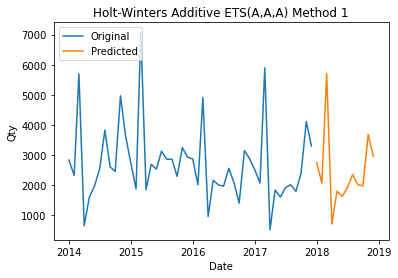

In [133]:
### Plot

fig2, ax = plt.subplots()
ax.plot(ABC_df_Pesticides_hwm['VALUE'], label='Original')
ax.plot(pred, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

# To check if Rainfall has any effect on Insecticides sales

In [134]:
Rainfall = [12.9,16.7,26.5,7.5, 20,25.8,71,33.5,67,10.8,0.2,9.4,12.1,6.6,70.7,34.9,8.3,43.5,127.9,84.4,32,3.8,2.3,0.2,
            0,1.1,20.7,0.6,26.8,34.8,155.1,133.8,13.7,5.2,0,0.9,33.8,0.3,7.2,3.7,10.1,121.8,67.7,74.7,91.8,0,1.8,4.2]

In [135]:
ABC_df_Pesticides['Rainfall'] = Rainfall[rolling_period - 3:]

Text(0, 0.5, 'Sales')

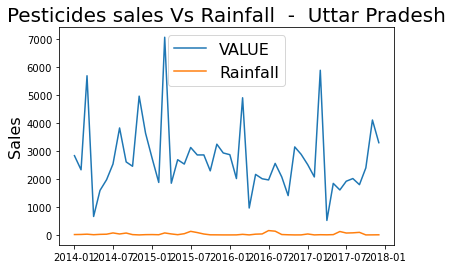

In [136]:
plt.plot(ABC_df_Pesticides)

plt.legend(('VALUE', 'Rainfall'), fontsize=16)

plt.title('Pesticides sales Vs Rainfall  -  Uttar Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

#Feature scaling for 'VALUE' column as Rainfall column

In [137]:
#Taking Rainfall and Value column on a common scale
ABC_df_Pesticides['VALUE'] = ABC_df_Pesticides['VALUE']/10000

In [138]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

array([<AxesSubplot:xlabel='MONTH'>, <AxesSubplot:xlabel='MONTH'>],
      dtype=object)

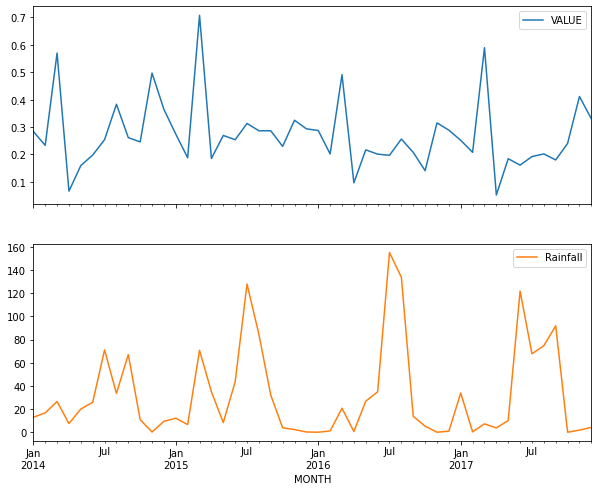

In [139]:
ABC_df_Pesticides.plot(subplots=True)

<AxesSubplot:xlabel='MONTH'>

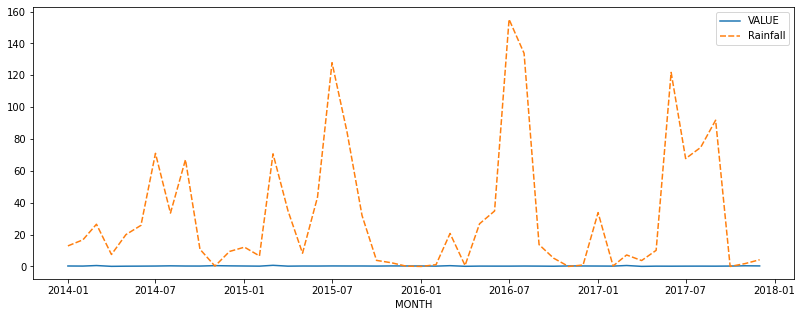

In [140]:
plt.figure(figsize = (30,5))
plt.subplot(1,2,1)
sns.lineplot(data=ABC_df_Pesticides)

In [141]:
#to find the coorelation betwween Rainfall and Value

In [142]:
col1 = ABC_df_Pesticides["Rainfall"]
col2 = ABC_df_Pesticides["VALUE"]

In [143]:
correlation = col1.corr(col2)
correlation

-0.0367111644224183

<AxesSubplot:>

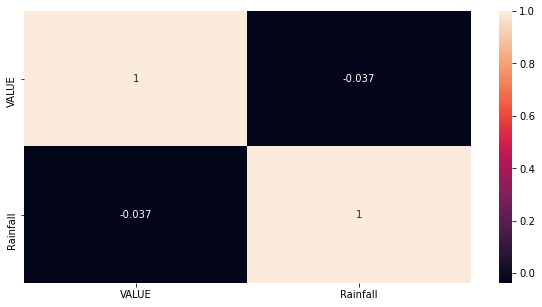

In [144]:
plt.figure(figsize = (10,5))
sns.heatmap(ABC_df_Pesticides.corr(),annot = True)